<a href="https://colab.research.google.com/github/M-ballabio1/DataScience_ML_DL-projects/blob/main/DeepLearning%20Projects/RNN_forecasting_BTC_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNN forecasting Stock Price of BTC

Utilizzeremo una variazione più performante di RNN: **Long Short Term Networks (LSTM).** 
Questo perchè le reti RNN soffrono del problema del vanishing gradient.

Qual è il problema del vanishing gradient?

Il problema del gradiente evanescente è una difficoltà riscontrata nell'addestramento di reti neurali artificiali con metodi di apprendimento basati su gradiente e retropropagazione. In tali metodi, ciascuno dei pesi della rete neurale riceve un aggiornamento proporzionale alla derivata parziale della funzione di errore rispetto al peso corrente in ogni iterazione dell'addestramento. Il problema è che in alcuni casi il gradiente sarà estremamente piccolo, impedendo efficacemente al peso di cambiare il suo valore. Nel peggiore dei casi, ciò potrebbe impedire completamente alla rete neurale di continuare l'addestramento. Come esempio della causa del problema, le funzioni di attivazione tradizionali come la funzione tangente iperbolica hanno gradienti nell'intervallo (0, 1) e la retropropagazione calcola i gradienti in base alla regola della catena. Questo ha l'effetto di moltiplicare n di questi piccoli numeri per calcolare i gradienti degli strati "anteriori" in una rete a n strati, il che significa che il gradiente (segnale di errore) diminuisce esponenzialmente con n mentre gli strati anteriori si allenano molto lentamente.

**Memoria a lungo termine (LSTM)**

Le unità (o blocchi) di memoria a lungo termine (LSTM) sono un'unità di costruzione per i livelli di una rete neurale ricorrente (RNN). Un RNN composto da unità LSTM è spesso chiamato rete LSTM. L'espressione "long short term" si riferisce al fatto che LSTM è un modello per la memoria a breve termine che può durare per un lungo periodo di tempo. Un LSTM è adatto per classificare, elaborare e prevedere serie temporali dati ritardi di dimensione e durata sconosciuti tra eventi importanti.

In [ ]:
pip install mplcyberpunk

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import os
import mplcyberpunk
plt.style.use('cyberpunk')

In [ ]:
from google.colab import files 

df = files.upload()

Saving btc.csv to btc.csv


In [ ]:
data = pd.read_csv('btc.csv', sep=';',error_bad_lines=False)
print(data)

            date           txVolume(USD)  ...  blockSize  blockCount
0     28/04/2013     687.986.834.462.941  ...   21597536         177
1     29/04/2013  11.381.284.537.973.300  ...   25676453         174
2     30/04/2013   8.426.632.385.465.560  ...   27042465         149
3     01/05/2013  12.068.253.251.662.100  ...   25727393         151
4     02/05/2013   9.337.532.862.924.960  ...   26388234         134
...          ...                     ...  ...        ...         ...
2263  09/07/2019  12.353.951.321.930.200  ...  177910427         154
2264  10/07/2019  15.371.220.780.936.500  ...  163860559         129
2265  11/07/2019  21.368.539.187.554.300  ...  161640234         129
2266  12/07/2019   2.012.421.181.011.170  ...  202117297         164
2267  13/07/2019  15.310.648.143.864.600  ...  147850145         141

[2268 rows x 17 columns]


#### Preprocessing data

In [ ]:
data = data['price(USD)'].values 
data = data.reshape(-1, 1)
print(data.shape)

(2268, 1)


In [ ]:
dataset_train = np.array(data[:int(data.shape[0]*0.8)])
dataset_test = np.array(data[int(data.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1814, 1)
(504, 1)


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.003442  ],
       [0.00339769],
       [0.00389029],
       [0.00363265],
       [0.00246711]])

In [ ]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.50125056],
       [0.49470715],
       [0.53203691],
       [0.54714978],
       [0.53157832]])

In [ ]:
def dataset_f(data):
  x=[]
  y=[]
  for i in range (50, data.shape[0]):
    x.append(data[i-50:i, 0])
    y.append(data[i, 0])
  x = np.array(x)
  y = np.array(y)
  return x,y

In [ ]:
x_train, y_train = dataset_f(dataset_train)
x_train[:1]

array([[0.003442  , 0.00339769, 0.00389029, 0.00363265, 0.00246711,
        0.00194514, 0.0015252 , 0.0022878 , 0.0024465 , 0.00225431,
        0.00211776, 0.00230326, 0.00228265, 0.00253513, 0.00242898,
        0.00238673, 0.00254956, 0.00221051, 0.00235581, 0.00256141,
        0.00283399, 0.00281904, 0.00278246, 0.00275773, 0.00280255,
        0.00284944, 0.00297826, 0.00332864, 0.00327145, 0.00334926,
        0.00315706, 0.00311738, 0.00328485, 0.00310708, 0.00310811,
        0.00313284, 0.00278246, 0.00269177, 0.00272578, 0.00275154,
        0.00260057, 0.0021899 , 0.00202965, 0.00164577, 0.0019503 ,
        0.00208684, 0.00207551, 0.00182663, 0.0016231 , 0.0016128 ]])

In [ ]:
x_test, y_test = dataset_f(dataset_test)
x_test[:1]

array([[0.50125056, 0.49470715, 0.53203691, 0.54714978, 0.53157832,
        0.56210292, 0.56851803, 0.58889696, 0.59070041, 0.58903608,
        0.55316299, 0.50923828, 0.48158116, 0.47827828, 0.45262762,
        0.4912806 , 0.46912966, 0.4712737 , 0.42366841, 0.42532501,
        0.42527348, 0.40304525, 0.42641789, 0.44061616, 0.45699196,
        0.45709295, 0.44662318, 0.4551612 , 0.44026268, 0.43437109,
        0.41899182, 0.40027876, 0.40760796, 0.36599372, 0.35161924,
        0.35731709, 0.34916552, 0.36242857, 0.38067686, 0.34936081,
        0.34767639, 0.33812071, 0.35303623, 0.3594431 , 0.34661906,
        0.3490939 , 0.35486028, 0.40358989, 0.40222854, 0.4086519 ]])

In [ ]:
#Reshape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Building Model

In [ ]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
if(not os.path.exists('stock_prediction.h6')):
    model.fit(x_train, y_train, epochs=35, batch_size=32)
    model.save('stock_prediction.h5')

Epoch 1/35
56/56 [==============================] - 15s 150ms/step - loss: 0.0041
Epoch 2/35
56/56 [==============================] - 8s 151ms/step - loss: 0.0028
Epoch 3/35
56/56 [==============================] - 8s 149ms/step - loss: 0.0015
Epoch 4/35
56/56 [==============================] - 9s 152ms/step - loss: 0.0020
Epoch 5/35
56/56 [==============================] - 8s 151ms/step - loss: 0.0013
Epoch 6/35
56/56 [==============================] - 9s 152ms/step - loss: 0.0016
Epoch 7/35
56/56 [==============================] - 8s 150ms/step - loss: 0.0019
Epoch 8/35
56/56 [==============================] - 8s 151ms/step - loss: 0.0020
Epoch 9/35
56/56 [==============================] - 8s 150ms/step - loss: 0.0013
Epoch 10/35
56/56 [==============================] - 8s 151ms/step - loss: 0.0013
Epoch 11/35
56/56 [==============================] - 9s 153ms/step - loss: 0.0011
Epoch 12/35
56/56 [==============================] - 8s 150ms/step - loss: 0.0010
Epoch 13/35
56/56 [=====

In [ ]:
model = load_model('stock_prediction.h5')

### View Results

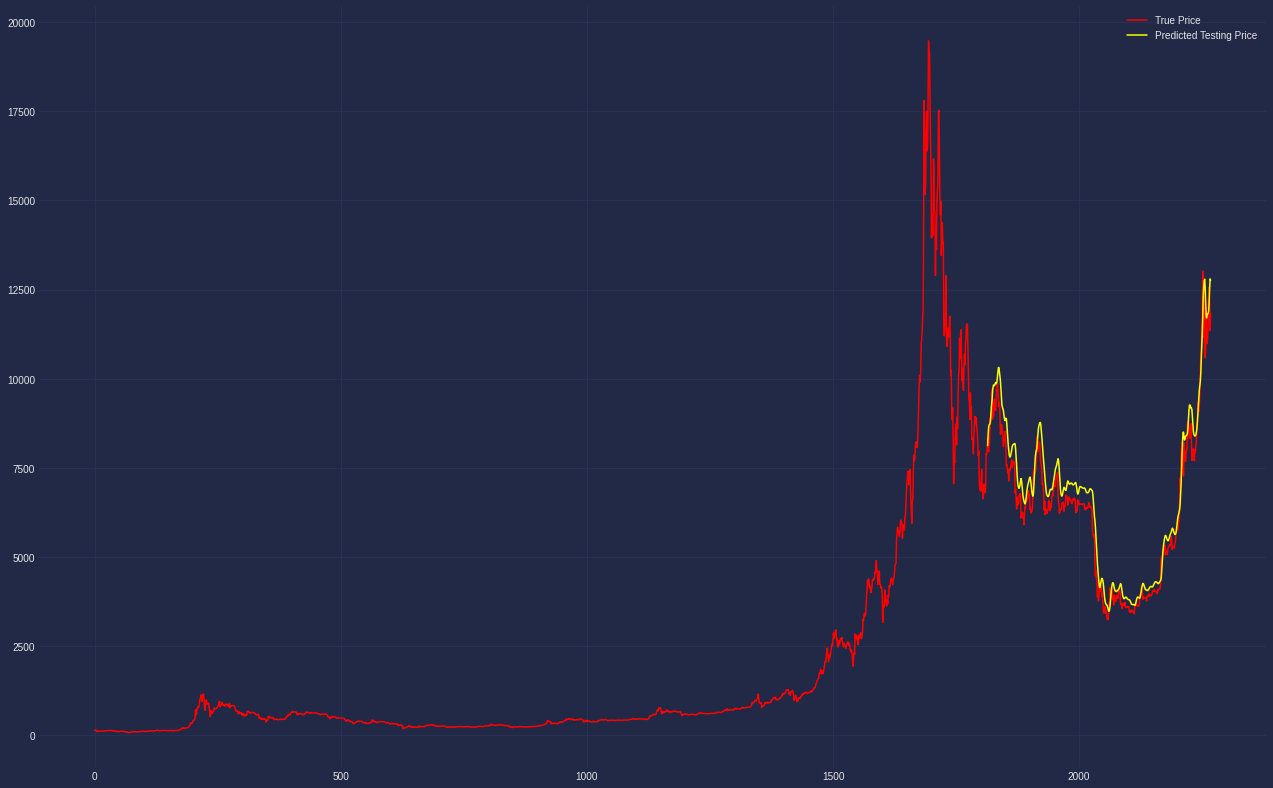

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(22,14))
plt.plot(data, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='yellow', label='Predicted Testing Price')
plt.legend()

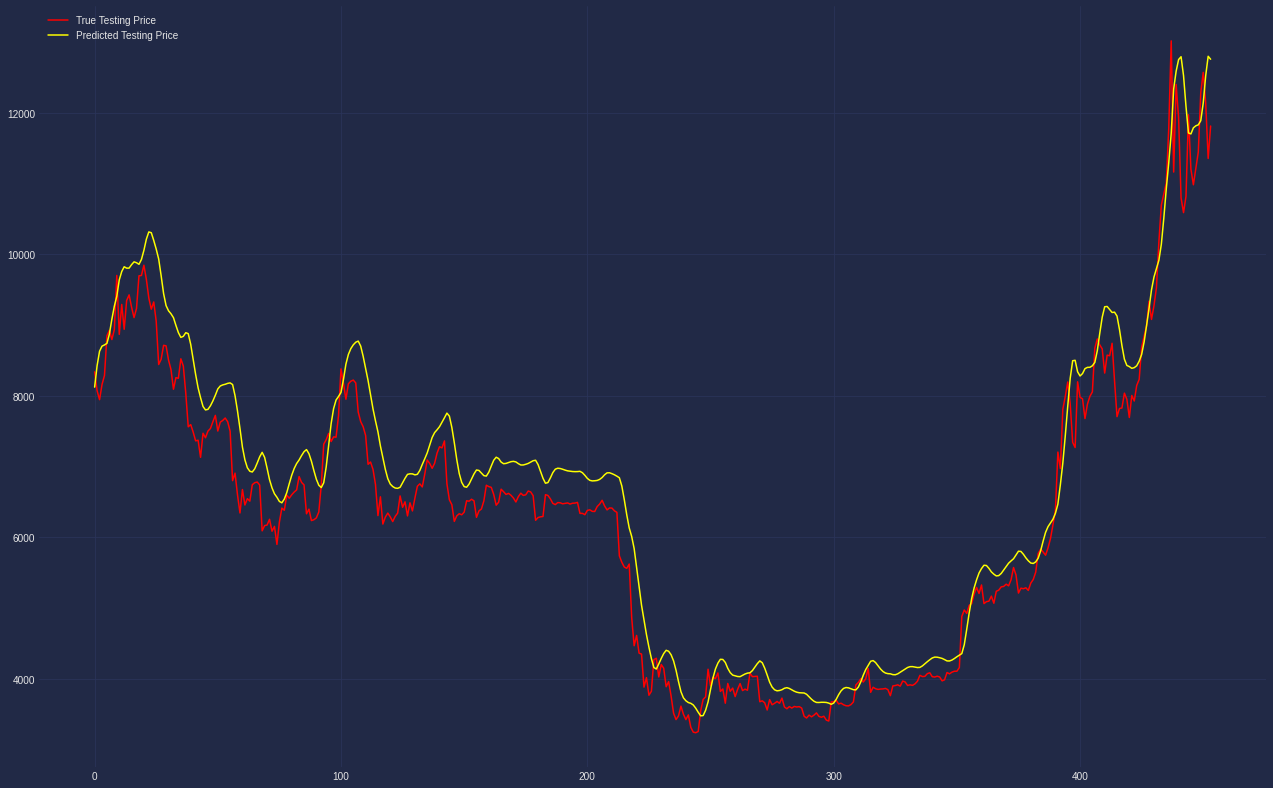

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(22,14))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='yellow', label='Predicted Testing Price')
plt.legend()

In [ ]:
x = x_test[-1]
num_timesteps = 100
preds = []
for i in range(num_timesteps):
    data1 = np.expand_dims(x, axis=0)
    prediction = model.predict(data1)
    prediction = scaler.inverse_transform(prediction)
    preds.append(prediction[0][0])
    x = np.delete(x, 0, axis=0) # delete first row
    x = np.vstack([x, prediction]) # add prediction

print(preds)

[12756.998, 47336.113, 44163.37, 45616.418, 45309.33, 45381.945, 45323.53, 45300.4, 45270.08, 45245.824, 45224.043, 45205.52, 45189.645, 45176.188, 45164.812, 45155.21, 45147.08, 45140.227, 45134.438, 45129.543, 45125.402, 45121.918, 45118.96, 45116.47, 45114.37, 45112.594, 45111.105, 45109.883, 45108.85, 45108.023, 45107.367, 45106.87, 45106.53, 45106.312, 45106.24, 45106.348, 45106.51, 45106.89, 45107.434, 45108.137, 45109.105, 45110.535, 45112.71, 45115.305, 45118.273, 45121.293, 45123.34, 45122.375, 45115.12, 45098.64, 45071.36, 45071.36, 45071.35, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.35, 45071.36, 45071.35, 45071.36, 45071.36, 45071.35, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.35, 45071.36, 45071.36, 45071.36, 45071.36, 45071.363, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.35, 45071.36, 

# GRU architecture:

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(x_train,y_train,epochs=50,batch_size=150)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
12/12 [==============================] - 9s 192ms/step - loss: 0.0287
Epoch 2/50
12/12 [==============================] - 2s 185ms/step - loss: 0.0219
Epoch 3/50
12/12 [==============================] - 2s 182ms/step - loss: 0.0155
Epoch 4/50
12/12 [==============================] - 2s 185ms/step - loss: 0.0098
Epoch 5/50
12/12 [==============================] - 2s 182ms/step - loss: 0.0054
Epoch 6/50
12/12 [==============================] - 2s 188ms/step - loss: 0.0026
Epoch 7/50
12/12 [==============================] - 2s 182ms/step - loss: 0.0017
Epoch 8/50
12/12 [==============================] - 2s 187ms/step - loss: 0.0015
Epoch 9/50
12/12 [==============================] - 2s 182ms/step - loss: 0.0016
Epoch 10/50
12/12 [==============================] - 2s 182ms/step - loss: 0.0015
Epoch 11/50
12/12 [==============================] - 2s 184ms/step - loss: 0.0016
Epoch 12/50
12/12 [==============================] - 2s 182ms/step - loss: 0.0014
Epoch 13/50
12/12 [======

In [ ]:
regressorGRU.save('stock_prediction.h7')

INFO:tensorflow:Assets written to: stock_prediction.h7/assets


INFO:tensorflow:Assets written to: stock_prediction.h7/assets


In [ ]:
regressorGRU = load_model('stock_prediction.h7')

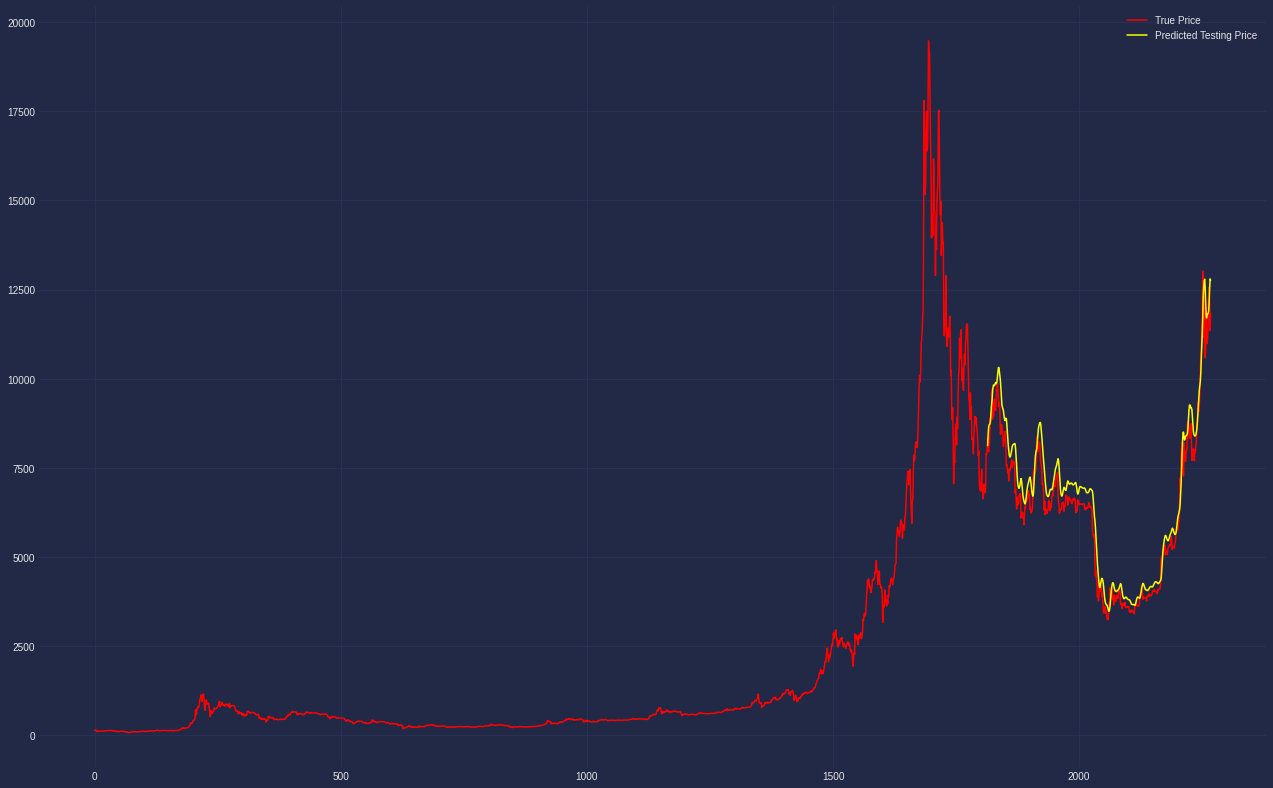

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(22,14))
plt.plot(data, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='yellow', label='Predicted Testing Price')
plt.legend()

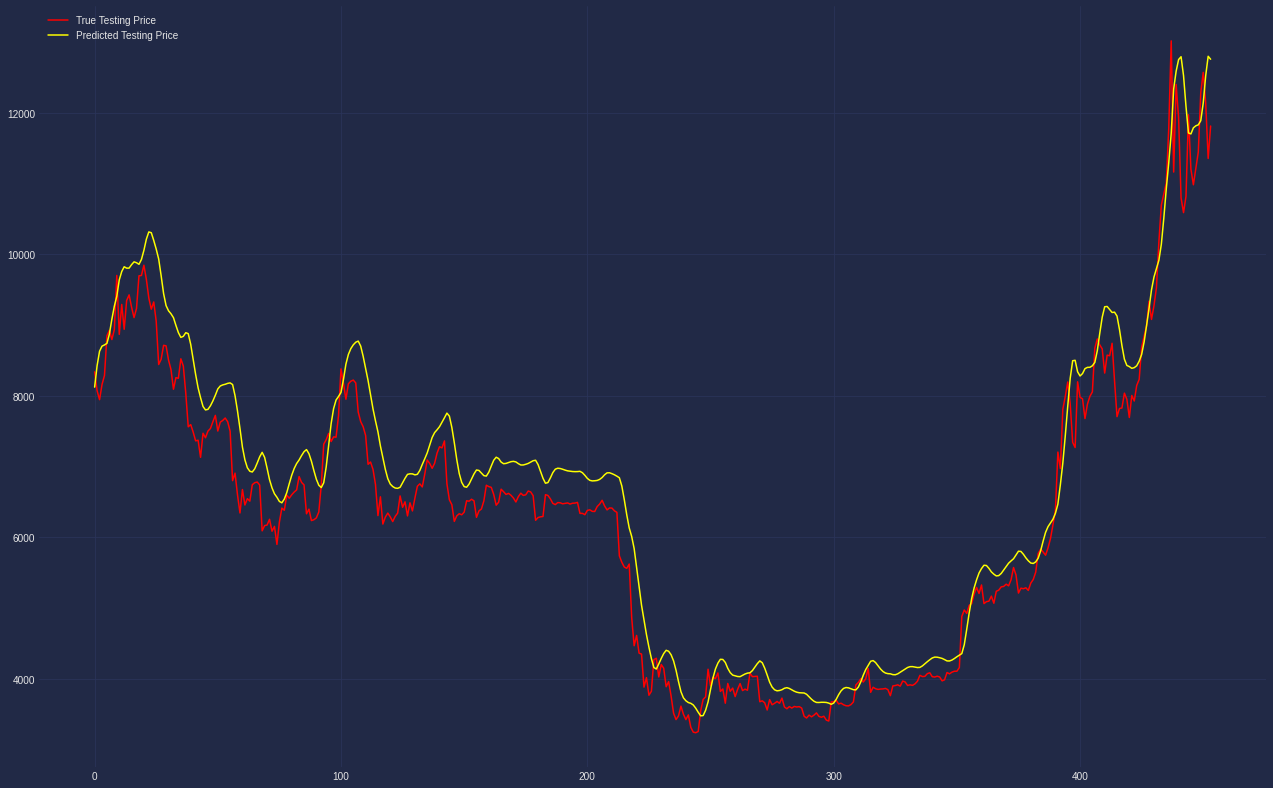

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(22,14))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='yellow', label='Predicted Testing Price')
plt.legend()

In [ ]:
x = x_test[-1]
num_timesteps = 100
preds = []
for i in range(num_timesteps):
    data1 = np.expand_dims(x, axis=0)
    prediction = model.predict(data1)
    prediction = scaler.inverse_transform(prediction)
    preds.append(prediction[0][0])
    x = np.delete(x, 0, axis=0) # delete first row
    x = np.vstack([x, prediction]) # add prediction

print(preds)

[12756.998, 47336.113, 44163.37, 45616.418, 45309.33, 45381.945, 45323.53, 45300.4, 45270.08, 45245.824, 45224.043, 45205.52, 45189.645, 45176.188, 45164.812, 45155.21, 45147.08, 45140.227, 45134.438, 45129.543, 45125.402, 45121.918, 45118.96, 45116.47, 45114.37, 45112.594, 45111.105, 45109.883, 45108.85, 45108.023, 45107.367, 45106.87, 45106.53, 45106.312, 45106.24, 45106.348, 45106.51, 45106.89, 45107.434, 45108.137, 45109.105, 45110.535, 45112.71, 45115.305, 45118.273, 45121.293, 45123.34, 45122.375, 45115.12, 45098.64, 45071.36, 45071.36, 45071.35, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.35, 45071.36, 45071.35, 45071.36, 45071.36, 45071.35, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.35, 45071.36, 45071.36, 45071.36, 45071.36, 45071.363, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.36, 45071.35, 45071.36, 